Here we will test out several forms of guess propagation. FOr any spectral fit, we require a prior. How to obtain this prior is always the pertinent question. Typically, curves are treated independently, so neighboring pixel information is not shared. This is wasting valuable information that could help in generating better priors.


1.   Random: arbitrary guesses on the coefficients
2.   Nearest-neighbor: average the nearest-neighbors such that it becomes the guess for the current selected pixel
3.   K-Means clustering: same as (2) but the average of the cluster becomes the guess for the current selected pixel
4.   Hierarchical clustering: same as (2) but propagate the fit of cluster means to children

More information found in our publication: N Creange et al 2021 *Mach. Learn.: Sci. Technol.* 2 045002

Authors: N. Creange, K. Kelley, C. Smith, D. Sando, O. Paul, N. Valanoor, S. Somnath, S. Jesse, S. V. Kalinin, R. K. Vasudevan

DOI: 10.13139/ORNLNCCS/1761194



# Load packages

In [2]:
#Run this cell then restart runtime; do not run it a second time.
!pip install git+https://github.com/pycroscopy/pycroscopy.git
!pip install pyUSID==0.0.8.1

  Cloning https://github.com/pycroscopy/pycroscopy.git to /tmp/pip-req-build-p66bihb6
  Running command git clone -q https://github.com/pycroscopy/pycroscopy.git /tmp/pip-req-build-p66bihb6


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyUSID as usid
import pycroscopy as px
import h5py
import time
import pickle
import os

#Prepare Data

##Load Data

In [10]:
# !gdown https://drive.google.com/uc?id=1sGLzkzCM4KDJWyfXWYno2eFG93VOgaEX
h5_path = '/content/Nagy_SuperR_BFO_BEPS_50x50_0001.h5'


Downloading...
From: https://drive.google.com/uc?id=1sGLzkzCM4KDJWyfXWYno2eFG93VOgaEX
To: /content/Nagy_SuperR_BFO_BEPS_50x50_0001.h5
100% 741M/741M [00:03<00:00, 194MB/s]


#Load Data

In [12]:
h5_f = h5py.File(h5_path, 'r+')
# main_dsets = usid.hdf_utils.get_all_main(h5_f)

In [16]:
h5_main = usid.hdf_utils.find_dataset(h5_f, 'Raw_Data')[0]
h5_sho_fit = usid.hdf_utils.find_results_groups(h5_main,'Raw_Data-SHO_Fit_000')[0]

In [ ]:
usid.hdf_utils.print_tree(h5_f)

In [ ]:
# h5_sho_fit = main_dsets[2]
amplitude = h5_sho_fit['Amplitude [V]']
phase = h5_sho_fit['Phase [rad]']

adjust = np.max(phase) - np.min(phase)
phase_wrap = []
for ii in range(phase.shape[0]):
  phase_wrap.append([x+adjust if x < -2 else x for x in phase[ii,:]])
phase = np.asarray(phase_wrap)
plt.figure()
plt.hist(phase.ravel(),bins=100)

PR_mat = amplitude*np.cos(phase)
PR_mat = -PR_mat.reshape(h5_sho_fit.pos_dim_sizes[0],h5_sho_fit.pos_dim_sizes[1],-1 )

plt.figure()

dc_vec_OF = h5_sho_fit.h5_spec_vals[0,:][np.logical_and(h5_sho_fit.h5_spec_vals[1,:]==0,h5_sho_fit.h5_spec_vals[2,:]==2)]
dc_vec_IF = h5_sho_fit.h5_spec_vals[0,:][np.logical_and(h5_sho_fit.h5_spec_vals[1,:]==1,h5_sho_fit.h5_spec_vals[2,:]==2)]
                                        
PR_OF = PR_mat[:,:,129::2] # off field
PR_IF = PR_mat[:,:,128::2] # on field

plt.plot(dc_vec_OF,PR_OF[11,9,:] , 'r-')
plt.plot(dc_vec_IF,PR_IF[11,9,:] , 'b-')

View Data

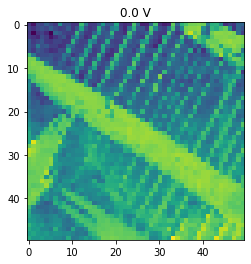

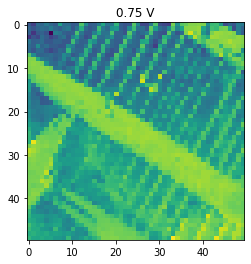

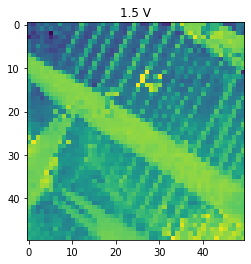

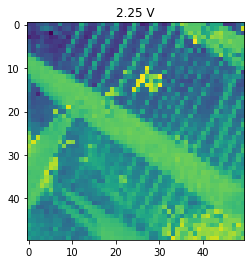

In [ ]:
for ind in range(4):
    plt.figure()
    plt.imshow(PR_OF[:,:,ind])
    plt.title(str(dc_vec_OF[ind])+' V')


#Load analysis modules

In [ ]:
from BGlib.be.analysis.prior_fitting import prior_fitting

In [29]:
"""
Fitting class for BEPS datasets using guessing propagation methods: nearest-neighbor or k-means

More information can be found in our publication: N. Creange et al. 2021 Mach. Learn.: Sci. Technol. 2 045002
"""

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from copy import deepcopy
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, erfinv

loop_metrics32 = np.dtype({'names': ['Area', 'Centroid x', 'Centroid y',
                                     'Rotation Angle [rad]', 'Offset'],
                           'formats': [np.float32, np.float32, np.float32,
                                       np.float32, np.float32]})

crit32 = np.dtype({'names': ['AIC_loop', 'BIC_loop', 'AIC_line', 'BIC_line'],
                   'formats': [np.float32, np.float32, np.float32,
                               np.float32]})

__field_names = ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'b_0', 'b_1', 'b_2', 'b_3',
                 'R2 Criterion']
loop_fit32 = np.dtype({'names': __field_names,
                       'formats': [np.float32 for name in __field_names]})
field_names = ['V+', 'V-', 'Imprint', 'R+', 'R-', 'Switchable Polarization',
               'Work of Switching', 'Nucleation Bias 1', 'Nucleation Bias 2']
switching32 = np.dtype({'names': field_names,
                        'formats': [np.float32 for name in field_names]})


def loop_fit_function(vdc, *coef_vec):
    """
    9 parameter fit function

    Parameters
    -----------
    vdc : 1D numpy array or list
        DC voltages
    coef_vec : 1D numpy array or list
        9 parameter coefficient vector

    Returns
    ---------
    loop_eval : 1D numpy array
        Loop values
    """
    from scipy.special import erf
    a = coef_vec[:5]
    b = coef_vec[5:]
    d = 1000

    v1 = np.asarray(vdc[:int(len(vdc) / 2)])
    v2 = np.asarray(vdc[int(len(vdc) / 2):])

    g1 = (b[1] - b[0]) / 2 * (erf((v1 - a[2]) * d) + 1) + b[0]
    g2 = (b[3] - b[2]) / 2 * (erf((v2 - a[3]) * d) + 1) + b[2]

    y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
    y2 = (g2 * erf((v2 - a[3]) / g2) + b[2]) / (b[2] + b[3])

    f1 = a[0] + a[1] * y1 + a[4] * v1
    f2 = a[0] + a[1] * y2 + a[4] * v2

    loop_eval = np.hstack((f1, f2))
    return loop_eval

class prior_fitting():

    def __init__(self, dc_vec, PR, method= 'K-Means', NN=None):
        self.h5_f = h5_f
        self.xdata0 = dc_vec
        self.PR_mat = PR
        self.method = method
        self.NN = NN

        self.p0_mat = [[]]*PR.shape[0]*PR.shape[1]
        self.p0_refs = [[]]*PR.shape[0]*PR.shape[1]
        self.bnds = (-100,100)
        self.fitted_loops_mat = [[]] * PR.shape[0] * PR.shape[1]
        self.SumSq = [[]] * PR.shape[0] * PR.shape[1]
        self.ref_counts = np.arange(PR.shape[0] * PR.shape[1]).reshape((PR.shape[0], PR.shape[1]))  # reference for finding neighboring pixels


    def _roll_check(self):
        max_x = np.where(self.xdata0==np.max(self.xdata0))[0]
        self.max_x = max_x
        if max_x != 0 or max_x != len(self.xdata0):
            self.xdata0 = np.roll(self.xdata0, -max_x)
            self.dum = 1
        else:
            self.xdata0 = self.xdata0
            self.dum = 0

    def _cal_all_mean(self):
        all_mean = np.mean(np.mean(self.PR_mat,axis=0),axis=0)
        if self.dum == 1:
            all_mean = np.roll(all_mean, -self.max_x)
        return all_mean

    def loop_resid(self, coef_vec, vdc, ydata):
        y = loop_fit_function(vdc, *coef_vec)
        res = ydata - y
        ss = res @ res
        return ss

    def calc_mean_fit(self):
        p0_vals = []
        opt_vals = []
        res = []
        all_mean = self._cal_all_mean()

        for kk in range(20):
            p0 = np.random.normal(0.1, 5, 9)
            p0_vals.append(p0)
            try:
                vals_min, pcov = curve_fit(loop_fit_function, self.xdata0, all_mean, p0=p0, maxfev=10000)
            except:
                continue
            opt_vals.append(vals_min)
            fitted_loop = loop_fit_function(self.xdata0, *vals_min)
            yres = all_mean - fitted_loop
            res.append(yres @ yres)

        popt = opt_vals[np.argmin(res)]
        popt_mean = deepcopy(popt)
        p0_mat = [popt] * self.PR_mat.shape[0] * self.PR_mat.shape[1]
        plt.figure()
        plt.plot(self.xdata0, all_mean, 'ko')
        fitted_loop = loop_fit_function(self.xdata0, *popt)
        plt.plot(self.xdata0, fitted_loop, 'k')
        print('Done with average fit')

        return popt_mean, p0_mat, fitted_loop, all_mean

    def do_fit(self):
        self._roll_check()
        popt_mean, p0_mat, fitted_loop, all_mean = self.calc_mean_fit()

        # Set up plotting figure
        cmap = plt.cm.plasma_r
        scale = (0, 1)
        fig, ax = plt.subplots(figsize=(8, 8))
        cbaxs = fig.add_axes([0.92, 0.125, 0.02, 0.755])

        if self.method == 'K-Means':  # ---> use average fit for start point for kmeans average fits
            size = self.PR_mat.shape[0] * self.PR_mat.shape[1]
            n_clusters = int(size / 100)
            PR_mat_flat = self.PR_mat.reshape(size, int(self.PR_mat.shape[2]))
            kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(PR_mat_flat)
            labels = kmeans.labels_
            p0_clusters = []
            cluster_loops = []
            for pp in range(n_clusters):
                opt_vals = []
                res = []
                clust = PR_mat_flat[labels == pp]
                PR_mean = np.mean(clust, axis=0)
                if self.dum == 1:
                    PR_mean = np.roll(PR_mean, -self.max_x)
                cluster_loops.append(PR_mean)
                p0 = p0_mat[0]
                try:
                    popt, pcov = curve_fit(loop_fit_function, self.xdata0, PR_mean, p0=p0, maxfev=10000)
                except:
                    kk = 0
                    p0 = np.random.normal(0.1, 5, 9)
                    while kk < 20:
                        try:
                            vals_min, pcov = curve_fit(loop_fit_function, self.xdata0, all_mean, p0=p0, maxfev=10000)
                        except:
                            continue
                        kk += 1
                        opt_vals.append(vals_min)
                        fitted_loop = loop_fit_function(self.xdata0, *vals_min)
                        yres = PR_mean - fitted_loop
                        res.append(yres @ yres)
                        popt = opt_vals[np.argmin(res)]
                p0_clusters.append(popt)
                fitted_loop = loop_fit_function(self.xdata0, *popt)

            # -----------------
            # Start loop for fitting each pixel
            # -----------------
        count = -1
        for ii in range(self.PR_mat.shape[0]):
            xind = ii
            for jj in range(self.PR_mat.shape[1]):
                count += 1  # used to keep track of popt vals
                yind = jj
                ydata0 = self.PR_mat[xind, yind, :]
                if self.dum == 1:
                    ydata = np.roll(ydata0, -self.max_x)
                else:
                    ydata = ydata0

        # -----------------
        # SET UP METHOD FOR INITIAL VALUES
        # -----------------
                if self.method == 'Neighbor':
                    xs = [ii + k for k in range(-self.NN, self.NN + 1)]
                    ys = [jj + k for k in range(-self.NN, self.NN + 1)]
                    nbrs = [(n, m) for n in xs for m in ys]
                    cond = [all(x >= 0 for x in list(y)) for y in nbrs]
                    nbrs = [d for (d, remove) in zip(nbrs, cond) if remove]
                    cond2 = [all(x < self.ref_counts.shape[0] for x in list(y)) for y in
                             nbrs]  # assumes PR_mat is square....
                    nbrs = [d for (d, remove) in zip(nbrs, cond2) if remove]
                    NN_indx = [self.ref_counts[v] for v in nbrs]
                    prior_coefs = [p0_mat[k] for k in NN_indx if len(p0_mat[k]) != 0]
                    if prior_coefs == []:
                        p0 = popt
                    else:
                        p0 = np.mean(prior_coefs, axis=0)
                    self.p0_refs[count] = p0
                    try:
                        popt, pcov = curve_fit(loop_fit_function, self.xdata0, ydata, p0=p0, maxfev=10000, bounds=self.bnds)
                    except:
                        fitted_loop = loop_fit_function(self.xdata0, *p0)
                        plt.figure()
                        plt.plot(self.xdata0, fitted_loop, 'r')
                        plt.plot(self.xdata0, ydata, 'k')
                        continue
                    p0_mat[count] = popt  # saves fitted coefficients for the index

                if self.method == 'K-Means':
                    lab = labels[count]
                    p0 = p0_clusters[lab]
                    try:
                        popt, pcov = curve_fit(loop_fit_function, self.xdata0, ydata, p0=p0, maxfev=10000)
                    except:
                        p0 = popt_mean
                        try:
                            popt, pcov = curve_fit(loop_fit_function, self.xdata0, ydata, p0=p0, maxfev=10000)
                        except:
                            continue
                    self.p0_refs[count] = p0
                    p0_mat[count] = popt  # saves fitted coefficients for the index

                # -----------------
                # ----------------- Common for all methods ---------------------
                # -----------------

                fitted_loop = loop_fit_function(self.xdata0, *p0_mat[count])
                self.fitted_loops_mat[count] = fitted_loop
                ss = r2_score(ydata, fitted_loop)
                self.SumSq[count] = ss
                sh = np.floor(1 + (2 ** 16 - 1) * ((ss) - scale[0]) / (scale[1] - scale[0]))
                if sh < 1:
                    sh = 1
                if sh > 2 ** 16:
                    sh = 2 ** 16

                cz = ax.plot(ii, jj, c=cmap(sh / (2 ** 16)), marker='s', markersize=7)

        scbar = plt.cm.ScalarMappable(cmap=plt.cm.plasma_r, norm=plt.Normalize(vmin=scale[0], vmax=scale[1]))
        scbar._A = []
        cbar = plt.colorbar(scbar, cax=cbaxs)
        cbar.ax.set_ylabel('$R^2$', rotation=270, labelpad=20)

        return fig, ax, self.p0_refs, p0_mat, self.SumSq, self.fitted_loops_mat

    def calc_switching_coef_vec(self,loop_coef_vec, nuc_threshold):
        """
        Calculates the physical loop parameters from the array of loop parameters.
        Parameters
        ----------
        loop_coef_vec : numpy.ndarray
            Array of loop coeffiecients
        nuc_threshold : float
            Nucleation threshold
        Returns
        -------
        switching_coef_vec : numpy.ndarray
            Array of loop parameters
        """
        switching_coef_vec = np.zeros(shape=loop_coef_vec.shape[0], dtype=switching32)

        anv = loop_coef_vec[:, :5].T
        bnv = loop_coef_vec[:, 5:].T

        nuc_v01a = bnv[2] * erfinv((nuc_threshold * bnv[2] + nuc_threshold * bnv[3] - bnv[2]) / bnv[2]) + anv[3]
        nuc_v01b = bnv[3] * erfinv((nuc_threshold * bnv[2] + nuc_threshold * bnv[3] - bnv[2]) / bnv[3]) + anv[3]

        nuc_v01 = np.where(np.isfinite(nuc_v01a), nuc_v01a,
                           np.where(np.isfinite(nuc_v01b), nuc_v01b, -1E-10))

        nuc_v02a = bnv[0] * erfinv(
            ((1 - nuc_threshold) * bnv[0] + (1 - nuc_threshold) * bnv[1] - bnv[0]) / bnv[0]) + anv[2]
        nuc_v02b = bnv[1] * erfinv(
            ((1 - nuc_threshold) * bnv[0] + (1 - nuc_threshold) * bnv[1] - bnv[0]) / bnv[1]) + anv[2]

        nuc_v02 = np.where(np.isfinite(nuc_v02a), nuc_v02a,
                           np.where(np.isfinite(nuc_v02b), nuc_v02b, -1E-10))

        switching_coef_vec['V+'] = loop_coef_vec[:, 3]
        switching_coef_vec['V-'] = loop_coef_vec[:, 2]
        switching_coef_vec['Imprint'] = (loop_coef_vec[:, 2] + loop_coef_vec[:, 3]) / 2
        switching_coef_vec['R+'] = loop_coef_vec[:, 0] + loop_coef_vec[:, 1]
        switching_coef_vec['R-'] = loop_coef_vec[:, 0]
        switching_coef_vec['Switchable Polarization'] = loop_coef_vec[:, 1]
        switching_coef_vec['Work of Switching'] = np.abs(loop_coef_vec[:, 3] -
                                                         loop_coef_vec[:, 2]) * np.abs(loop_coef_vec[:, 1])

        switching_coef_vec['Nucleation Bias 1'] = nuc_v01
        switching_coef_vec['Nucleation Bias 2'] = nuc_v02

        return switching_coef_vec.reshape([-1, 1])

    field_names = ['V+', 'V-', 'Imprint', 'R+', 'R-', 'Switchable Polarization',
                   'Work of Switching', 'Nucleation Bias 1', 'Nucleation Bias 2']
    switching32 = np.dtype({'names': field_names,
                            'formats': [np.float32 for name in field_names]})


#Do Fitting

Input the dc voltage vector, the Piezoresponse matrix, and the method for prior propagation fitting: 'K-Means' or 'Neighbor'.  Note that if you choose 'Neighbor' you will also need the input variable NN (NN=2 or some other value).

In [ ]:
beps_prior_fitting = prior_fitting.prior_fitting(dc_vec, PR, method = 'K-Means')
fig,ax,p0_refs,p0_mat,SumSq,fitted_loops_mat = beps_prior_fitting.do_fit()

Save Fitting

In [ ]:
mdir = '/content'
dict = {'fig':fig,'ax':ax,'p0_refs':p0_refs,'p0_mat':p0_mat,'ss':SumSq,'fitted_loops_mat':fitted_loops_mat}

output = open(os.path.join(mdir,"data.pkl"), "wb")
pickle.dump(dict, output)
output.close()

In [ ]:
fig.savefig(os.path.join(mdir,'figure.eps'),format='eps',bbox_inches = 'tight')

# Do Coefficient Calculations

In [ ]:
coef_mat_kmeans = beps_prior_fitting.calc_switching_coef_vec(p0_mat,0.03)